<a href="https://colab.research.google.com/github/yejinPARK48/VerifyNews_using_Transformer/blob/main/FakeNews_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/WELFake_Dataset.csv')
print(data.head())


   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


## 2. Data Loading and Preprocessing

In [ ]:
# Check the Data
print(data.columns)


Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')


I have renamed a column because HuggingFace transformers recognize 'labels rather than 'label' as target column name.

In [ ]:
data.drop('Unnamed: 0',axis=1,inplace=True)

data.rename(columns={'label':'labels'},inplace=True)

data.head()

,title,text,labels
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
data.shape

(72134, 3)

In [ ]:
# Null values
data.isna().sum()

,0
title,558
text,39
labels,0


In [ ]:
# Remove missing values
data.dropna(subset=['title', 'text'], inplace=True)
data.dropna(axis=0,inplace=True)
# Check results
print(data.shape)
print(data.isna().sum())

(71537, 3)
title     0
text      0
labels    0
dtype: int64


In [ ]:
# Check number of duplicate rows
print(f"Number of duplicate rows: {data.duplicated().sum()}")

# Remove duplicate rows
data.drop_duplicates(inplace=True)
print(f"Data shape after removing duplicates: {data.shape}")

Number of duplicate rows: 8416
Data shape after removing duplicates: (63121, 3)


In [ ]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

In [ ]:
data.head()

,title,text,labels
71361,Donald Trump Responds To Mockery Over Fake Sw...,"Last night, at a rally in Melbourne, Florida, ...",1
11496,Tweetwave,This time it's true no pantsTweetwave More Of ...,1
20292,Rubio says prospect of Trump president is 'wor...,(Reuters) - U.S. Senator Marco Rubio said on W...,0
38855,Trump lifts Cyber Command status to boost cybe...,WASHINGTON (Reuters) - President Donald Trump ...,0
20416,The 7 Biggest Republican Lies About The Econo...,"In two-and-a-half minutes, former U.S. Secreta...",1


## 3. Exploratory Data Analysis

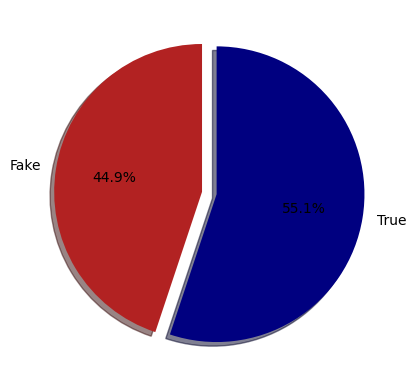

In [ ]:
import matplotlib.pyplot as plt

# Draw a pie chart
label_size = [data['labels'].sum(), len(data['labels']) - data['labels'].sum()]

plt.pie(label_size,
        explode=[0.1, 0],
        colors=['firebrick', 'navy'],
        startangle=90,
        shadow=True,
        labels=['Fake', 'True'],
        autopct='%1.1f%%')

plt.show()

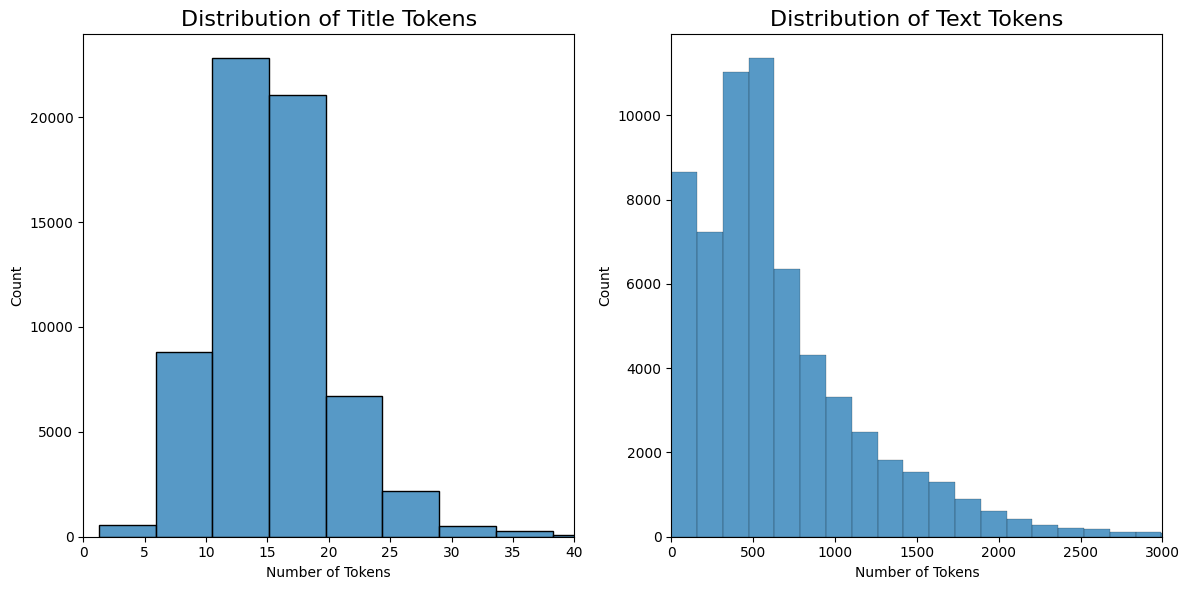

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Token calculation: Estimate the number of tokens by multiplying each word count by 1.3 on average.
#https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
title_token_counts = data['title'].map(lambda text: len(text.split()) * 1.3)
text_token_counts = data['text'].map(lambda text: len(text.split()) * 1.3)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 'Title token' distribution visualization
sns.histplot(title_token_counts, bins=20, ax=axes[0])
axes[0].set_title("Distribution of Title Tokens", fontsize=16)
axes[0].set_xlabel("Number of Tokens")
axes[0].set_xlim(0, 40)

# 'Text token' distribution visualization
sns.histplot(text_token_counts, bins=200, ax=axes[1])
axes[1].set_title("Distribution of Text Tokens", fontsize=16)
axes[1].set_xlabel("Number of Tokens")
axes[1].set_xlim(0, 3000)

# Layout
plt.tight_layout()
plt.show()


The token distribution for titles is more concentrated and smaller in range, making it computationally efficient for model training. On the other hand, the token distribution for texts is broader, indicating higher variability and larger input sizes, which could increase the computational cost when processing with models like BERT.

In [ ]:
from transformers import BertTokenizer
import pandas as pd

# 1. Load the data
titles = data['title']

# 2. Text refinement function
def clean_text(text):
    # Remove special characters
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    # Convert to lowercase
    text = text.lower()
    return text

# Convert to refined Title data
cleaned_titles = titles.apply(clean_text)

I calculated the estimated number of tokens for title data to limit the tokenization length.

In [ ]:
# Calculate average length of title data
title_token_mean = title_token_counts.mean()
print(f"Average token length for titles: {title_token_mean:.2f}")
##Result: 15.58

# Calculating percentages below 32
percentage_below_32 = (title_token_counts <= 32).mean() * 100
print(f"Percentage of titles with token length <= 32: {percentage_below_32:.2f}%")
##Result: 99.15%

I conducted wordcloud on the title data of real news and fake news.

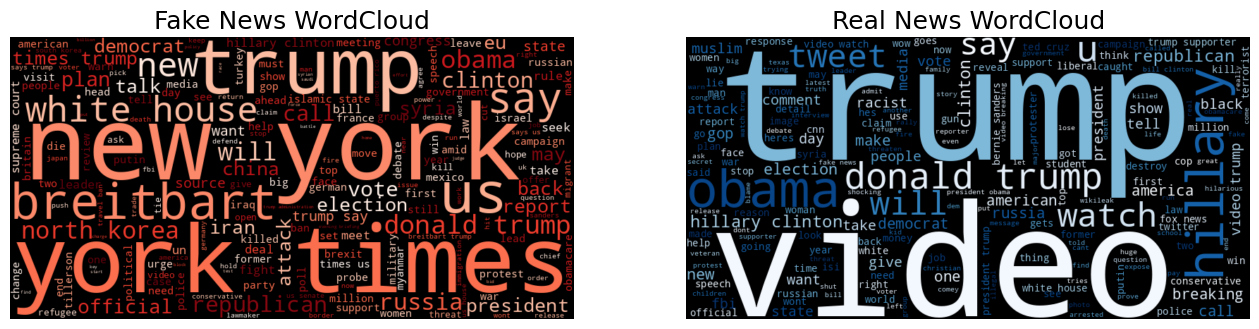

In [ ]:
from wordcloud import WordCloud

# Separate fake news and real news titles
fake_titles = data[data['labels'] == 0]['title']
real_titles = data[data['labels'] == 1]['title']

# Applying the refinement function
cleaned_fake_titles = fake_titles.apply(clean_text)
cleaned_real_titles = real_titles.apply(clean_text)

# Combine text data
fake_text = " ".join(cleaned_fake_titles)
real_text = " ".join(cleaned_real_titles)

#Fake News Word Cloud
fake_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Reds'
).generate(fake_text)

# Real News Word Cloud
real_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Blues'
).generate(real_text)

# Visualization
plt.figure(figsize=(16, 8))

#fake news
plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title("Fake News WordCloud", fontsize=18)
plt.axis("off")

# Real News
plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title("Real News WordCloud", fontsize=18)
plt.axis("off")

plt.show()


## 4. BERT modeling


In [ ]:
#3. Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#4. Tokenization, padding and truncation handling
max_length = 32  # Set fixed sequence length
encoded_titles = tokenizer(
    cleaned_titles.tolist(),  # Convert to list format
    padding='max_length',     # padding to a fixed length
    truncation=True,          # Cut if length exceeds
    max_length=max_length,    # Set maximum length
    return_tensors="pt"       # Return as PyTorch tensor (TensorFlow is "tf")
)

# 5. Check the output format
print(encoded_titles.keys())  # 'input_ids', 'attention_mask', 'token_type_ids'
print(encoded_titles['input_ids'][0])  # Output the token ID of the first sample

# 6. Example of results
input_ids = encoded_titles['input_ids']
attention_mask = encoded_titles['attention_mask']

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([  101,  6221,  8398, 16412,  2000, 12934,  7301,  2058,  8275,  4467,
         2886,  7374,  2000,  4756,  2115,  1037,  2125,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


In [ ]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import torch

# Create the entire dataset
labels = torch.tensor(data['labels'].values)
dataset = TensorDataset(input_ids, attention_mask, labels)

# 70% Train, 30% Temp (Validation + Test)
train_size = 0.7
train_dataset, temp_dataset = train_test_split(dataset, train_size=train_size)

# 70% Train, 15% Validation, 15% Test
val_size = 0.5
val_dataset, test_dataset = train_test_split(temp_dataset, train_size=val_size)

# Check
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 44184
Validation dataset size: 9468
Test dataset size: 9469


In [ ]:
from torch.utils.data import DataLoader

batch_size = 16  # Set batch size

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check (first batch)
for batch in train_loader:
    input_ids, attention_mask, labels = batch
    print("Input IDs:", input_ids.shape)
    print("Attention Mask:", attention_mask.shape)
    print("Labels:", labels.shape)
    break


Input IDs: torch.Size([16, 32])
Attention Mask: torch.Size([16, 32])
Labels: torch.Size([16])


In [ ]:
from transformers import BertForSequenceClassification
import torch

# BERT model definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Pre-trained model
    num_labels=2  # For binary classification
)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Setting up the optimizer and loss function
from transformers import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

# Setting hyperparameter candidates
param_grid = {
    'lr': [2e-5, 3e-5],
    'eps': [1e-8]
}

# Generate all combinations
grid = list(ParameterGrid(param_grid))

# Optimal performance variables
best_accuracy = 0
best_params = {}

for params in grid:
    print(f"Trying parameters: {params}")
    # Optimizer settings
    optimizer = AdamW(model.parameters(), lr=params['lr'], eps=params['eps'])

    # Learning loop
    for epoch in range(3):  # Fixed number of epochs
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1} | Loss: {total_loss / len(train_loader):.4f}")

    # evaluation
    model.eval()
    val_preds, val_labels_list = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            val_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels_list, val_preds)
    print(f"Validation Accuracy with params {params}: {val_accuracy:.4f}")

    # Update the optimal combination
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Trying parameters: {'eps': 1e-08, 'lr': 2e-05}


Epoch 1: 100%|██████████| 2762/2762 [04:58<00:00,  9.27it/s]


Epoch 1 | Loss: 0.0361


Epoch 2: 100%|██████████| 2762/2762 [04:57<00:00,  9.28it/s]


Epoch 2 | Loss: 0.0227


Epoch 3: 100%|██████████| 2762/2762 [04:57<00:00,  9.28it/s]


Epoch 3 | Loss: 0.0188


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Accuracy with params {'eps': 1e-08, 'lr': 2e-05}: 0.9209
Trying parameters: {'eps': 1e-08, 'lr': 3e-05}


Epoch 1: 100%|██████████| 2762/2762 [04:57<00:00,  9.28it/s]


Epoch 1 | Loss: 0.0283


Epoch 2: 100%|██████████| 2762/2762 [04:57<00:00,  9.27it/s]


Epoch 2 | Loss: 0.0231


Epoch 3: 100%|██████████| 2762/2762 [04:57<00:00,  9.28it/s]


Epoch 3 | Loss: 0.0193
Validation Accuracy with params {'eps': 1e-08, 'lr': 3e-05}: 0.9206
Best Parameters: {'eps': 1e-08, 'lr': 2e-05}
Best Validation Accuracy: 0.9209


In [ ]:
# Check test data accuracy
model.eval()
test_preds, test_labels_list = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        test_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(test_labels_list, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9273


              precision    recall  f1-score   support

           0       0.93      0.94      0.93      5196
           1       0.92      0.92      0.92      4273

    accuracy                           0.93      9469
   macro avg       0.93      0.93      0.93      9469
weighted avg       0.93      0.93      0.93      9469



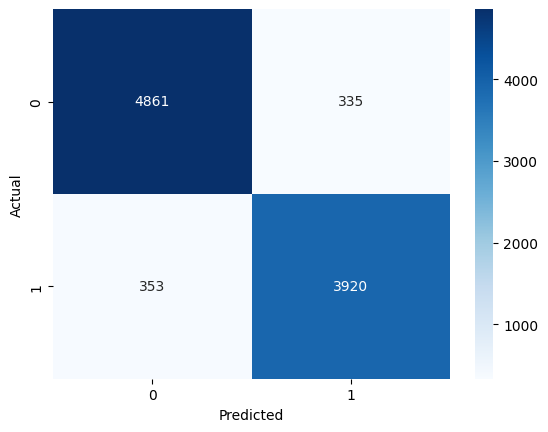

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print performance report
print(classification_report(test_labels_list, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels_list, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
